# CNN 卷积神经网络

### BP 反向传播算法
##### 目标:
优化网络中的参数是的损失函数最小化

##### 基本思路:

1. 给定参数初始值，计算出所有节点的计算值和激活值；
2. 根据损失函数的变化不断调整权重，不断逼近最优结果，使损失函数值最小。即将前向传播得到的结果通过损失函数𝐽(𝒙)计算，通过损失函数𝐽(𝒙)计算得到的梯度，来更新网络中的各个参数，使得损失函数变小。
3. 循环迭代完所有的训练数据或者损失值达到设定的阈值，算法结束

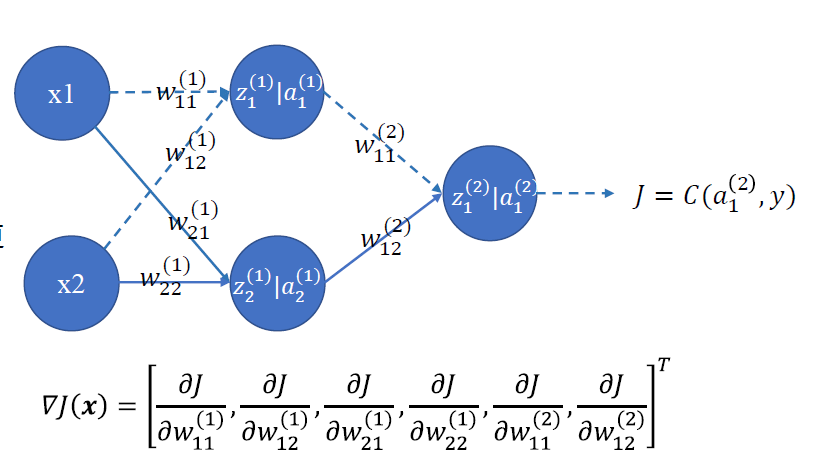

$$
\nabla J(\boldsymbol{x}) = \left[
\frac{\partial J}{\partial w_{11}^{(1)}},
\frac{\partial J}{\partial w_{12}^{(1)}},
\frac{\partial J}{\partial w_{21}^{(1)}},
\frac{\partial J}{\partial w_{22}^{(1)}},
\frac{\partial J}{\partial w_{11}^{(2)}},
\frac{\partial J}{\partial w_{12}^{(2)}}
\right]^T
$$


$$
w_{ij}^{(l)} = w_{ij}^{(l)} - \alpha \times \frac{\partial E}{\partial w_{ij}^{(l)}}
$$


##### 缺陷

1. 梯度越来越稀疏（下降速度慢）：从顶层越往下，误差校正信号越来越小
2. 收敛到局部最小值（陷入局部最优）：尤其是从远离最优区域开始的时候（随机值初始化会导致这种情况的发生）

##### 解决办法

1. 调整权重调整的幅度（𝛼）
2. 使用不同的权重初始化
    1. 初始化值不同，结果可能不同
    2. 对权重调整过程进行干预
3. 使用随机梯度下降方法



### CNN 基本模型构成

除了数据的输入层和输出层，卷积神经网络包括三个基本的模块：

1. 卷积层:对输入数据进行特征提取
2. 池化层:对卷积层所输出的特征进行选择
3. 全连接层: 将选择出来的特征进行整合并且实现分类

##### 卷积
卷积运算的结果是对原图产生一系列线性激活响应，需要加入非线性激活函数获得非线性的激活响应，提升模型对非线性问具体的处理能力。


$$
S(i,j) = (I * K)(i,j) = \sum_{m}\sum_{n} I(i + m, j + n)K(m,n)
$$

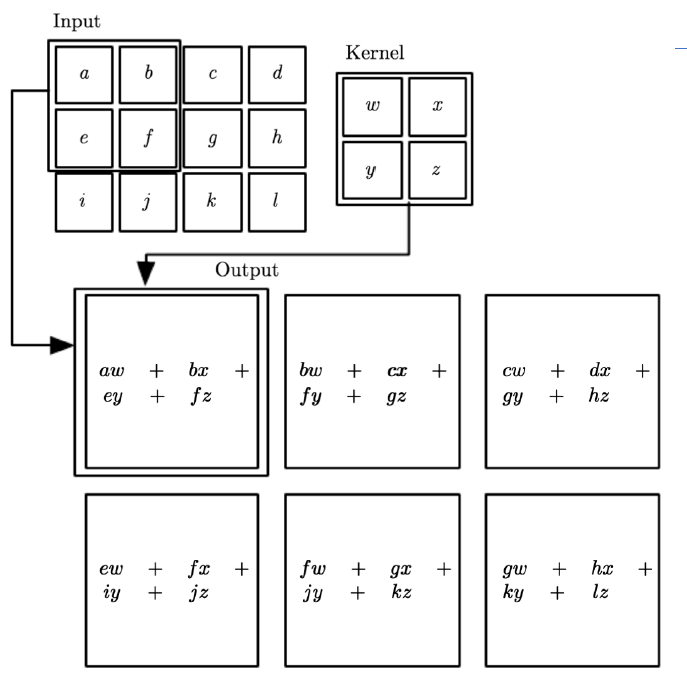



全连接神经网络中每个节点都会受到上一层所有节点的影响，各个层之间通过矩阵乘法相连， 是一种稠密的连接。而使用卷积操作，可以使得当前层的节点只受上一层部分节点的影响，可以极大的减少参数的数量。

可以按照图片处理的方式理解，卷积的过程类似于图像从高像素（清晰）转化为低像素（模糊）的过程



##### 池化
在卷积过程中，有几个卷积核我们就会得到几张不同值的特征图，此时数据量仍然较为庞大，池化操作可以进一步降低数据量。

池化分为:

1. 最大池化，取所选择池化尺寸的窗口中的最大值（例:2×2的窗口保留最大值来更新特征图）
2. 平均池化，取所选择池化尺寸的窗口中的最小值

##### 全连接层
与前面讲过的全连接层神经网络相同

##### 平移不变性
简单理解为，当输入数据在空间上平移时，神经网络的响应不变输出结果不会因为输入数据在空间上的平移而改变。在图像类的任务当中，如果要识别图中是否有一只狗，那么无论这只狗在图片的什么位置，算法应该都能将其识别出来，在使用卷积网络时，这种特性是天然支持的。

### 案例：分析K线图来评估股票价格趋势


## 数据读取与划分

In [1]:
## 使用GPU的话需要对电脑进行配置
use_gpu = True
use_dataparallel = True

In [2]:
import os
import sys
sys.path.insert(0, '..')

## 基本的数据处理函数
import time
import datetime
import numpy as np
import pandas as pd
from tqdm import tqdm

## 引入torch模块并且设置随机数种子
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split
torch.manual_seed(42)

## 定义两个字典，IMAGE_WIDTH 和 IMAGE_HEIGHT
## 根据不同时间间隔（如5分钟、20分钟、60分钟）设定对应的图像宽度和高度
IMAGE_WIDTH = {5: 15, 20: 60, 60: 180}
IMAGE_HEIGHT = {5: 32, 20: 64, 60: 96} 

选取 1993-2001年的数据作为训练集，剩下的作为测试集

In [3]:
## 选取 1993-2001年的数据作为训练集，剩下的作为测试集
train_year_list = np.arange(1993,2001,1)

images = []
label_df = []

for year in train_year_list:
    # np.memmap读取二进制图像数据文件并将将扁平的一维数据重新变为三维数组（图像数量，图像高度，图像宽度）
    images.append(np.memmap(os.path.join("./monthly_20d", f"20d_month_has_vb_[20]_ma_{year}_images.dat"), dtype=np.uint8, mode='r').reshape(
                        (-1, IMAGE_HEIGHT[20], IMAGE_WIDTH[20])))
    label_df.append(pd.read_feather(os.path.join("./monthly_20d", f"20d_month_has_vb_[20]_ma_{year}_labels_w_delay.feather")))
    
images = np.concatenate(images)
label_df = pd.concat(label_df)

print(images.shape)
print(label_df.shape)

(793019, 64, 60)
(793019, 8)


In [16]:
## label_df 文件
label_df.head()

,Date,StockID,MarketCap,Ret_5d,Ret_20d,Ret_60d,Ret_month,EWMA_vol
0,1993-01-29,10001,-15120.000,3.240260e-07,0.035714,0.065641,0.017857,0.000417
1,1993-02-26,10001,15390.000,-8.771723e-03,0.002584,0.073561,0.011456,0.000342
2,1993-03-31,10001,15318.750,-8.771614e-03,0.105263,0.117841,0.070175,0.000471
3,1993-04-30,10001,-16393.750,3.278655e-02,-0.008199,0.085991,-0.008199,0.000389
4,1993-05-28,10001,-16259.375,2.809882e-02,0.086608,0.136763,0.103326,0.000566


In [7]:
## 二进制图像数据文件
year = 2000
path = os.path.join("./monthly_20d", f"20d_month_has_vb_[20]_ma_{year}_images.dat")
height = 60
width = 64

In [12]:
example_data = np.memmap(path, dtype=np.uint8, mode='r')
num_images = example_data.size // (height * width)
images = data.reshape((num_images, height, width))


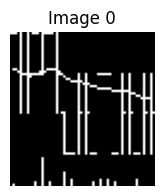

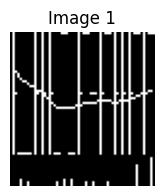

In [15]:
import matplotlib.pyplot as plt
# 展示前5张图像
for i in range(2):
    plt.figure(figsize=(2, 2))
    plt.imshow(images[i], cmap='gray')
    plt.title(f"Image {i}")
    plt.axis('off')  # 不显示坐标轴
    plt.show()

构建DataSet

In [19]:
## 构建DataSet类
class MyDataset(Dataset):
    
    def __init__(self, img, label):
        self.img = torch.Tensor(img.copy())
        self.label = torch.Tensor(label)
        self.len = len(img)
  
    def __len__(self):
        return self.len

    def __getitem__(self, idx):
        return self.img[idx], self.label[idx]

In [20]:
## 划分训练集和测试集，70%和30%
train_val_ratio = 0.7

## 生成索引
split_idx = int(images.shape[0] * 0.7)

# X:images,Y:(label_df.Ret_20d > 0).values，未来 20 天的收益是否大于0
train_dataset = MyDataset(images[:split_idx], (label_df.Ret_20d > 0).values[:split_idx])
val_dataset = MyDataset(images[split_idx:], (label_df.Ret_20d > 0).values[split_idx:])


In [21]:
## 使用DataLoader分批次把数据喂给模型并且打乱

# batch_size=128：每个 mini-batch 含 128 个样本；
# shuffle=True：每个 epoch 训练前会打乱数据；
# pin_memory=True：将数据加载进 CUDA 时更快（如果你使用 GPU 训练的话）
train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True, pin_memory=True)

# batch_size=256：验证阶段通常不需要梯度计算，可适当用更大的批次加快推理
# shuffle=False：验证集不需要打乱
val_dataloader = DataLoader(val_dataset, batch_size=256, shuffle=False, pin_memory=True)

## 模型搭建与可视化

In [22]:
## 搭建CNN模型，3个卷积池化层，一个全连接层
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        #卷积加池化层Layer1，设定输入（单通道图像）输出（卷积核的数量）通道数量，卷积核大小（5，3）和步长（高3宽1）
        # 设置空洞卷积，高度方向膨胀2，宽度方向膨胀1，注意参数数量并没有改变
        # 对个通道进行归一化，加速训练稳定网络
        # 激活函数使用LeakyReLU，允许小负值通过（防止神经元“死亡”）
        # 最大池化，池化窗口大小是 (2,1)，步长也是 (2,1)，即在高度方向上，每2个像素取一个最大值（尺寸缩小一半），宽度方向上不缩小，步长1
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=(5,3), stride=(3,1), dilation=(2,1), padding=(12,1)),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(negative_slope=0.01, inplace=True),
            nn.MaxPool2d((2, 1), stride=(2, 1)),
        )
        ## 卷积加池化层Layer2
        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=(5,3), stride=(3,1), dilation=(2,1), padding=(12,1)),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(negative_slope=0.01, inplace=True),
            nn.MaxPool2d((2, 1), stride=(2, 1)),
        )
         #卷积加池化层Layer3
         #每一层都继续扩大特征维度、压缩空间维度，提取更高级的图像特征
        self.layer3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=(5,3), stride=(3,1), dilation=(2,1), padding=(12,1)),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(negative_slope=0.01, inplace=True),
            nn.MaxPool2d((2, 1), stride=(2, 1)),
        )
        
        # 全连接层
        # Dropout(p=0.5)：防止过拟合，训练时随机丢弃 50% 的神经元。
        # 输入特征长度是 46080，这是从卷积层输出特征的数量
        # 输出 2 表示二分类（比如 0=不涨，1=上涨）
        
        self.fc1 = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(46080, 2),
        )
        
        # 激活函数，将两类得分转为概率，Softmax 输出
        self.softmax = nn.Softmax(dim=1)

    # 前向传播
    def forward(self, x):
        x = x.reshape(-1,1,64,60)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = x.reshape(-1,46080)
        x = self.fc1(x)
        x = self.softmax(x)
        return x


In [23]:
## 初始化模型并且输出模型的结构信息
# 全连接层使用均匀初始化（每层输入输出的方差保持一致），并且设置偏置项为0
# 卷积层同样使用均匀初始化，但不处理偏置项
def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.)
    elif isinstance(m, nn.Conv2d):
        torch.nn.init.xavier_uniform_(m.weight)

In [26]:
device = 'cuda' if use_gpu else 'cpu'
net = Net().to(device)
net.apply(init_weights)

Net(
  (layer1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(5, 3), stride=(3, 1), padding=(12, 1), dilation=(2, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01, inplace=True)
    (3): MaxPool2d(kernel_size=(2, 1), stride=(2, 1), padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(5, 3), stride=(3, 1), padding=(12, 1), dilation=(2, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01, inplace=True)
    (3): MaxPool2d(kernel_size=(2, 1), stride=(2, 1), padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(5, 3), stride=(3, 1), padding=(12, 1), dilation=(2, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01, inplace=True)
    (3): MaxPoo

In [29]:
# 统计模型中参数的总数量,展示模型的大小和复杂度
count = 0
for name, parameters in net.named_parameters():
    print(name, ':', parameters.size())
    # 返回该参数张量中元素的总数（所有维度的乘积）
    count += parameters.numel()
    print(parameters.numel())
print('total_parameters : {}'.format(count))
# 举例说明，Layer1，对于1个通道的输入进行64个大小为5*3的卷积，所以参数为1*64*5*3
# 同时对于每个输出有1个偏置项，所以一共有64个偏置项

layer1.0.weight : torch.Size([64, 1, 5, 3])
960
layer1.0.bias : torch.Size([64])
64
layer1.1.weight : torch.Size([64])
64
layer1.1.bias : torch.Size([64])
64
layer2.0.weight : torch.Size([128, 64, 5, 3])
122880
layer2.0.bias : torch.Size([128])
128
layer2.1.weight : torch.Size([128])
128
layer2.1.bias : torch.Size([128])
128
layer3.0.weight : torch.Size([256, 128, 5, 3])
491520
layer3.0.bias : torch.Size([256])
256
layer3.1.weight : torch.Size([256])
256
layer3.1.bias : torch.Size([256])
256
fc1.1.weight : torch.Size([2, 46080])
92160
fc1.1.bias : torch.Size([2])
2
total_parameters : 708866


In [30]:
# https://netron.app/,onnx文件拖入该网站可以看到具体的结构
import torch.onnx
# 构造一个与模型输入形状匹配的随机张量（batch=1，channel=1，高=64，宽=60）
x = torch.randn([1,1,64,60]).to(device)
torch.onnx.export(net,               # model being run
                  x,                         # 模型输入
                  "./cnn_baseline.onnx",   # 导出文件路径
                  export_params=False,        # 是否把模型参数（权重）存储进文件，False表示不存储
                  opset_version=10,          # ONNX版本，10是一个稳定版本
                  do_constant_folding=False,  # 是否做常量折叠优化
                  input_names = ['input_images'],   # 输入张量名称
                  output_names = ['output_prob'], # 输出张量名称
                  dynamic_axes={'input_images' : {0 : 'batch_size'},    # 指定输入张量第0维是动态变化的batch大小
                                 'output_prob' : {0 : 'batch_size'}})   # 输出张量第0维同样是动态batch大小

## 模型训练与评估

In [11]:
# 用于训练模型的函数，它每个 epoch 执行一次训练过程
def train_loop(dataloader, net, loss_fn, optimizer):
    
    
    #dataloader：训练数据加载器（train_dataloader）。
    #net：上面构建的卷积神经网络模型
    #loss_fn：损失函数
    #optimizer：优化器，BP的时候优化权重使用
    
    running_loss = 0.0 # running_loss：记录整个 epoch 的平均损失。
    current = 0        # 累计样本数，用于计算加权平均 loss
    
    net.train()        # 切换模型为训练模式,启用 dropout 和 batchnorm 的训练行为
    
    # 批次训练循环（使用 tqdm 显示进度）
    with tqdm(dataloader) as t:
        for batch, (X, y) in enumerate(t):
            X = X.to(device)
            y = y.to(device)
            y_pred = net(X)
            loss = loss_fn(y_pred, y.long())## 计算损失
            
            optimizer.zero_grad() # 清除旧的梯度信息
            loss.backward()       # 反向传播计算梯度
            optimizer.step()      # 更新权重
            
            # 更新平均损失
            running_loss = (len(X) * loss.item() + running_loss * current) / (len(X) + current)
            current += len(X)
            t.set_postfix({'running_loss':running_loss})
    
    return running_loss   # 返回每epoch的平均损失

In [12]:
# 用于验证模型的函数，没有梯度和权重更新等环节
def val_loop(dataloader, net, loss_fn):

    running_loss = 0.0
    current = 0
    net.eval()## 使用验证模式
    
    with torch.no_grad():
        with tqdm(dataloader) as t:
            for batch, (X, y) in enumerate(t):
                X = X.to(device)
                y = y.to(device)
                y_pred = net(X)
                loss = loss_fn(y_pred, y.long())

                running_loss += loss.item()
                running_loss = (len(X) * running_loss + loss.item() * current) / (len(X) + current)
                current += len(X)
            
    return running_loss

In [13]:
if use_gpu and use_dataparallel and 'DataParallel' not in str(type(net)):
    net = net.to(device)
    net = nn.DataParallel(net)

In [14]:
## 定义损失函数为交叉熵损失
loss_fn = nn.CrossEntropyLoss()
# 使用Adam优化器更新参数模型，学习率设置为0.00001，缓慢收敛
optimizer = torch.optim.Adam(net.parameters(), lr=1e-5)


In [ ]:
start_epoch = 0

# 用于实现 early stopping，如果验证集损失连续 5 个 epoch 没有下降，就提前停止训练，防止过拟合
min_val_loss = 1e9
last_min_ind = -1
early_stopping_epoch = 5

# 初始化 TensorBoard 的记录器（日志写入器），会在同级目录下出现一个runs的文件夹
from torch.utils.tensorboard import SummaryWriter
tb = SummaryWriter()

In [15]:
start_time = datetime.datetime.now().strftime('%Y%m%d_%H-%M-%S')
os.makedirs(os.path.join("pt",start_time),)

# 设置总训练轮数为100轮，依次训练
epochs = 100
for t in range(start_epoch, epochs):
    print(f"Epoch {t}\n-------------------------------")
    time.sleep(0.2)
    
   #  应用自定义的训练集和验证集的函数
    train_loss = train_loop(train_dataloader, net, loss_fn, optimizer)
    val_loss = val_loop(val_dataloader, net, loss_fn)
    
    # 用 TensorBoard 记录训练损失变化
    tb.add_histogram("train_loss", train_loss, t)
    
    # 模型保存
    torch.save(net, './pt'+os.sep+start_time+os.sep+'baseline_epoch_{}_train_{:5f}_val_{:5f}.pt'.format(t, train_loss, val_loss)) 
    
    # 早停策略，如果当前验证损失变小，则更新最小值及其对应的 epoch
    if val_loss < min_val_loss:
        last_min_ind = t
        min_val_loss = val_loss
    # 如果已经 early_stopping_epoch （5）轮都没有提升，则停止训练，防止过拟合
    elif t - last_min_ind >= early_stopping_epoch:
        break

print('Done!')
print('Best epoch: {}, val_loss: {}'.format(last_min_ind, min_val_loss))

Epoch 0
-------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 930/930 [00:26<00:00, 34.89it/s]


Epoch 1
-------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 930/930 [00:22<00:00, 40.62it/s]


Epoch 2
-------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 930/930 [00:22<00:00, 40.56it/s]


Epoch 3
-------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 930/930 [00:22<00:00, 40.66it/s]


Epoch 4
-------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 930/930 [00:22<00:00, 40.54it/s]


Epoch 5
-------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 930/930 [00:22<00:00, 40.71it/s]


Epoch 6
-------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 930/930 [00:22<00:00, 40.56it/s]


Done!
Best epoch: 1, val_loss: 0.693060862993489


In [16]:
# 使用01-19年的数据进行测试
test_year_list = np.arange(2001,2020,1)

In [ ]:
# 读入数据
images = []
label_df = []
for year in test_year_list:
    images.append(np.memmap(os.path.join("./monthly_20d", f"20d_month_has_vb_[20]_ma_{year}_images.dat"), dtype=np.uint8, mode='r').reshape(
                        (-1, IMAGE_HEIGHT[20], IMAGE_WIDTH[20])))
    label_df.append(pd.read_feather(os.path.join("./monthly_20d", f"20d_month_has_vb_[20]_ma_{year}_labels_w_delay.feather")))
    
images = np.concatenate(images)
label_df = pd.concat(label_df)

In [18]:
dataset = MyDataset(images, (label_df.Ret_20d > 0).values)

In [19]:
test_dataloader = DataLoader(dataset, batch_size=2048, shuffle=False)

In [21]:
# 加载已经训练好的模型
net_path = './pt/20231115_15-51-08/baseline_epoch_1_train_0.717068_val_0.693061.pt'
device = 'cuda' if use_gpu else 'cpu'
net = torch.load(net_path)

In [22]:
# 定义评估函数，还需要返回的预测值
def eval_loop(dataloader, net, loss_fn):
    # dataloader，验证集或者测试集的数据
    # net,神经网络
    # loss_fn，损失函数
    
    running_loss = 0.0
    total_loss = 0.0
    current = 0
    
    net.eval()  # 设置模式为评估模式，停用dropout等功能
    # 存储真实值和预测值
    target = []
    predict = []
    with torch.no_grad():
        with tqdm(dataloader) as t:
            for batch, (X, y) in enumerate(t):
                X = X.to(device)
                y = y.to(device)
                y_pred = net(X)
                target.append(y.detach())
                predict.append(y_pred.detach())
                loss = loss_fn(y_pred, y.long())
                # 实现动态加权平均损失，从而能够看到平滑变化的loss
                running_loss = (len(X) * loss.item() + running_loss * current) / (len(X) + current)
                current += len(X)
                t.set_postfix({'running_loss':running_loss})
            
    return total_loss, torch.cat(predict), torch.cat(target)

In [23]:
# 使用交叉损失函数
loss_fn = nn.CrossEntropyLoss()
test_loss, y_pred, y_target = eval_loop(test_dataloader, net, loss_fn)

# 讲解过转化为概率，并且取出每个样本属于第一类的概率，再转化为numpy数组
predict_logit = (torch.nn.Softmax(dim=1)(y_pred)[:,1]).cpu().numpy()

100%|████████████████████████████████████████████████████████████| 686/686 [02:35<00:00,  4.42it/s, running_loss=0.696]


In [24]:
from matplotlib import pyplot as plt

In [25]:
# 基准收益的结果，全选，作为回测收益的基线
threshold = 0.

label_df['ret'] = (predict_logit>threshold) * label_df.Ret_20d
label_filtered = label_df[predict_logit>threshold]
ret_baseline = label_filtered .groupby(['Date'])['Ret_20d'].mean()

# CNN讯号预测，只有模型认为为正的概率比较高的时候才进行投资
threshold = 0.58

label_df['ret'] = (predict_logit>threshold) * label_df.Ret_20d
label_filtered = label_df[predict_logit>threshold]
ret_cnn = label_filtered .groupby(['Date'])['Ret_20d'].mean()

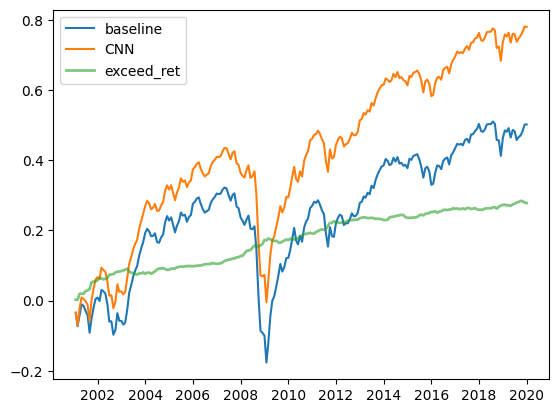

In [27]:
# 分别计算累计对数收益率
log_ret_baseline = np.log10((ret_baseline+1).cumprod().fillna(method='ffill'))
log_ret_cnn = np.log10((ret_cnn+1).cumprod().fillna(method='ffill'))
fig = plt.figure()
plt.plot(log_ret_baseline, label='baseline')
plt.plot(log_ret_cnn, label='CNN')
plt.plot(log_ret_cnn - log_ret_baseline, alpha=0.6, lw=2, label='exceed_ret')
plt.legend()
plt.show()
fig.savefig('performance1.png',dpi=300)

CNN的结果远远优于我们所选用的简单的baseline，预测效果非常不错